<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_09_class_imbalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load & Preprocess Data

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from data_utils import (load_data_from_url, clean_column_names, remove_id_column,
                        rename_columns, convert_categorical, preprocess_data, split_data, plot_class_distribution,
                        create_preprocessing_pipeline, add_model_to_pipeline, evaluate_model,
                        hyperparameter_tuning, create_weighted_model)
from resampling_utils import evaluate_model, aggregate_reports, extract_key_metrics, plot_key_metrics, evaluate_thresholds

# Define your parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'


# Load and Preprocess Data
data = preprocess_data(url, categorical_columns)

# Check if data is loaded and preprocessed correctly
if data is not None:
    # Split the data
    X_train, X_test, y_train, y_test = split_data(data, target=target)

    # Define preprocessing steps for numerical and categorical columns
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()

    # Create preprocessing pipeline
    pipeline = create_preprocessing_pipeline(numeric_features, categorical_features)
else:
    print("Data preprocessing failed. Please check the URL and preprocessing steps.")

Preprocessing pipeline created successfully.


### Description of Class Imbalance

**Class imbalance** occurs when the number of instances in different classes of a dataset is significantly different. In other words, one class (the majority class) has many more instances than the other class (the minority class). This imbalance can cause issues in machine learning models, leading to biased and poor performance on the minority class.

### What Class Imbalance Is

1. **Uneven Distribution of Classes**:
   - Class imbalance refers to a situation where the classes in a dataset are not equally represented. For example, in a binary classification problem, you might have 90% of instances belonging to class 0 and only 10% to class 1.

2. **Skewed Class Representation**:
   - When the dataset's class distribution is skewed, it means that the machine learning model will encounter many more instances of the majority class than the minority class during training.

### Why Class Imbalance Matters

1. **Biased Model Predictions**:
   - Machine learning models trained on imbalanced datasets tend to be biased towards the majority class. This means that the model will often predict the majority class, leading to high accuracy but poor performance on the minority class.

2. **Poor Minority Class Performance**:
   - In an imbalanced dataset, the minority class might have too few instances for the model to learn its patterns effectively. This can result in poor recall and precision for the minority class, making the model unreliable for detecting instances of that class.

3. **Misleading Accuracy Metrics**:
   - In imbalanced datasets, accuracy can be a misleading metric. A model that always predicts the majority class can have high accuracy but will fail to identify any minority class instances correctly. More informative metrics such as recall, precision, F1-score, and area under the ROC curve (AUC-ROC) should be used to evaluate model performance.

### Role of Class Imbalance in Machine Learning

1. **Impact on Training**:
   - Class imbalance affects how the model learns from the data. With an imbalanced dataset, the loss function might be dominated by the majority class, leading to a model that performs well on the majority class but poorly on the minority class.

2. **Evaluation Challenges**:
   - Evaluating models on imbalanced datasets requires careful consideration of metrics. Standard accuracy is not sufficient; metrics like recall, precision, F1-score, and AUC-ROC are more appropriate for assessing the performance on the minority class.

3. **Real-World Applications**:
   - Class imbalance is common in many real-world applications, such as fraud detection, medical diagnostics, and anomaly detection. In these scenarios, the minority class represents rare but critical events that need to be accurately identified.

### Strategies to Address Class Imbalance

1. **Class Weights**:
   - Assigning higher weights to the minority class in the loss function to ensure the model pays more attention to it.

2. **Resampling Techniques**:
   - **Oversampling**: Increasing the number of instances in the minority class by duplicating existing ones or generating new synthetic instances (e.g., SMOTE).
   - **Undersampling**: Reducing the number of instances in the majority class by randomly removing instances.

3. **Anomaly Detection Models**:
   - Using models specifically designed for detecting anomalies or rare events, which can be more effective in handling imbalanced data.

4. **Ensemble Methods**:
   - Combining multiple models to improve performance on the minority class, such as using bagging, boosting, or stacking.



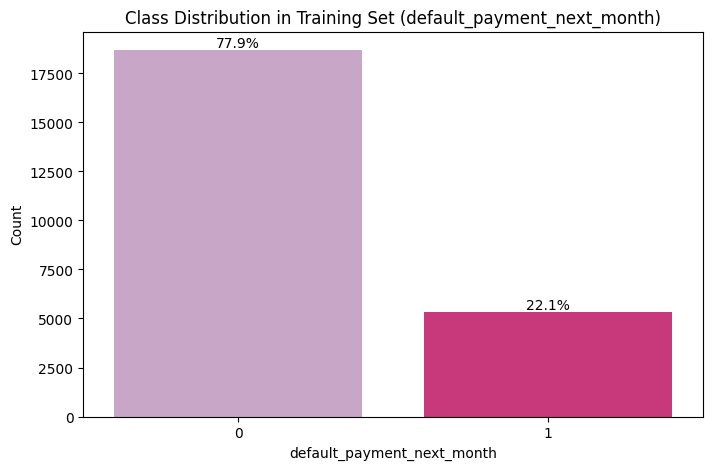

In [4]:
plot_class_distribution(y_train, target)

### Resample Data & Save Metrics

Classification Report for Logistic Regression with SMOTE:
               precision    recall  f1-score   support

           0       0.87      0.68      0.76      4673
           1       0.36      0.63      0.46      1327

    accuracy                           0.67      6000
   macro avg       0.61      0.66      0.61      6000
weighted avg       0.76      0.67      0.70      6000

Classification Report for Logistic Regression with Undersampling:
               precision    recall  f1-score   support

           0       0.87      0.69      0.77      4673
           1       0.37      0.63      0.46      1327

    accuracy                           0.68      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.76      0.68      0.70      6000

Classification Report for RandomForest with SMOTE:
               precision    recall  f1-score   support

           0       0.86      0.89      0.87      4673
           1       0.55      0.47      0.51      1327

    

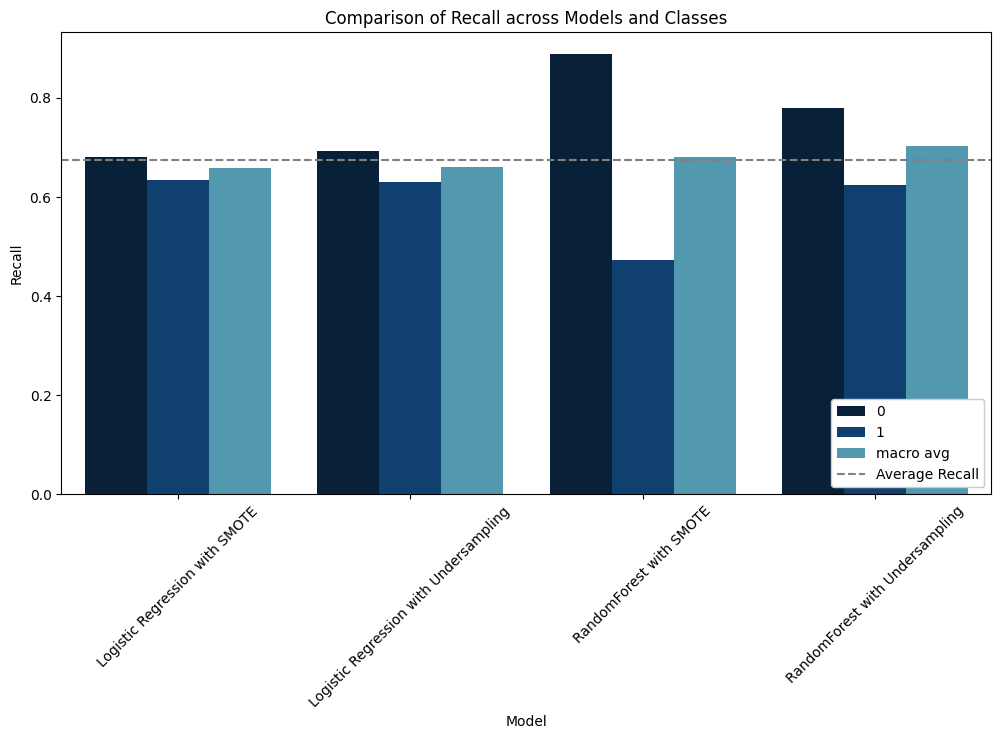

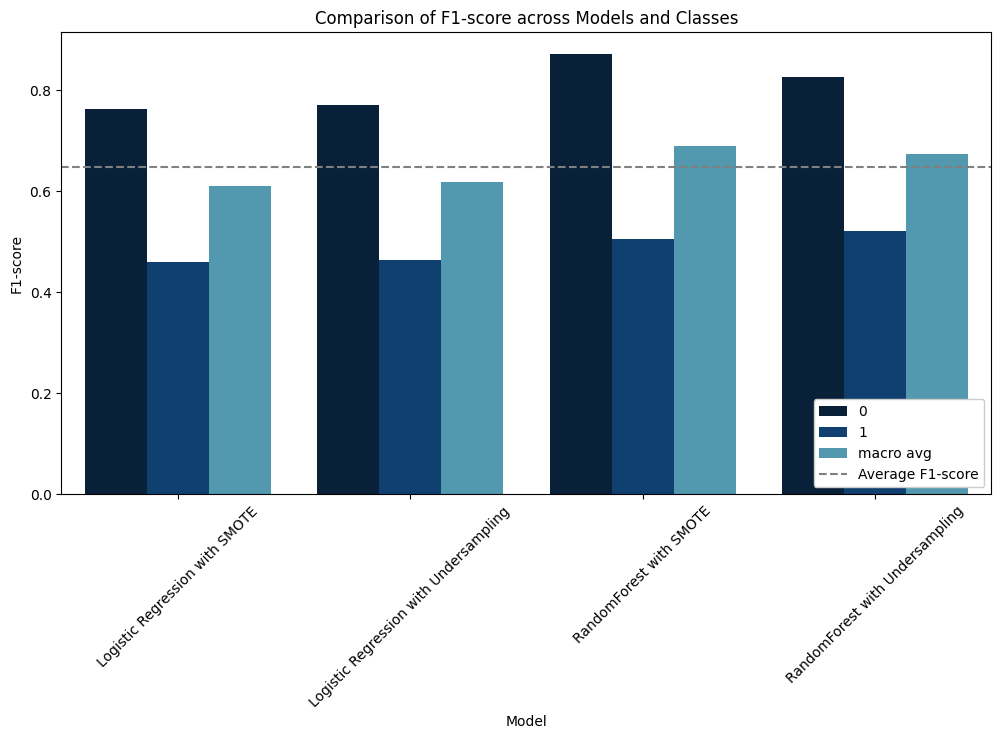

In [5]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from resampling_utils import aggregate_reports, extract_key_metrics, plot_key_metrics
from data_utils import evaluate_model

# Define the key metrics and classes you want to focus on
desired_metrics = ['recall', 'f1-score']
desired_classes = ['0', '1', 'macro avg']

# Initialize an empty list to store all reports
all_reports = []

# Logistic Regression with SMOTE
model = LogisticRegression(max_iter=500, random_state=42)
smote = SMOTE(random_state=42)
pipeline_with_smote = ImbPipeline(steps=[
    ('preprocessor', pipeline.named_steps['preprocessor']),
    ('smote', smote),
    ('model', model)
])
pipeline_with_smote.fit(X_train, y_train)
y_pred_smote = pipeline_with_smote.predict(X_test)
report_smote = evaluate_model(pipeline_with_smote, X_test, y_test, "Logistic Regression with SMOTE")
all_reports = aggregate_reports(all_reports, report_smote)

# Logistic Regression with Undersampling
undersample = RandomUnderSampler(random_state=42)
pipeline_with_undersample = ImbPipeline(steps=[
    ('preprocessor', pipeline.named_steps['preprocessor']),
    ('undersample', undersample),
    ('model', model)
])
pipeline_with_undersample.fit(X_train, y_train)
y_pred_undersample = pipeline_with_undersample.predict(X_test)
report_undersample = evaluate_model(pipeline_with_undersample, X_test, y_test, "Logistic Regression with Undersampling")
all_reports = aggregate_reports(all_reports, report_undersample)

# RandomForest with SMOTE
rf_model = RandomForestClassifier(random_state=42)
pipeline_with_rf_smote = ImbPipeline(steps=[
    ('preprocessor', pipeline.named_steps['preprocessor']),
    ('smote', smote),
    ('model', rf_model)
])
pipeline_with_rf_smote.fit(X_train, y_train)
y_pred_rf_smote = pipeline_with_rf_smote.predict(X_test)
report_rf_smote = evaluate_model(pipeline_with_rf_smote, X_test, y_test, "RandomForest with SMOTE")
all_reports = aggregate_reports(all_reports, report_rf_smote)

# RandomForest with Undersampling
pipeline_with_rf_undersample = ImbPipeline(steps=[
    ('preprocessor', pipeline.named_steps['preprocessor']),
    ('undersample', undersample),
    ('model', rf_model)
])
pipeline_with_rf_undersample.fit(X_train, y_train)
y_pred_rf_undersample = pipeline_with_rf_undersample.predict(X_test)
report_rf_undersample = evaluate_model(pipeline_with_rf_undersample, X_test, y_test, "RandomForest with Undersampling")
all_reports = aggregate_reports(all_reports, report_rf_undersample)

# Extract and display the key metrics
key_metrics_df = extract_key_metrics(all_reports, desired_metrics, desired_classes)
print(key_metrics_df)

# Plot key metrics
plot_key_metrics(key_metrics_df, desired_metrics, desired_classes)


#### Plot Key Metrics

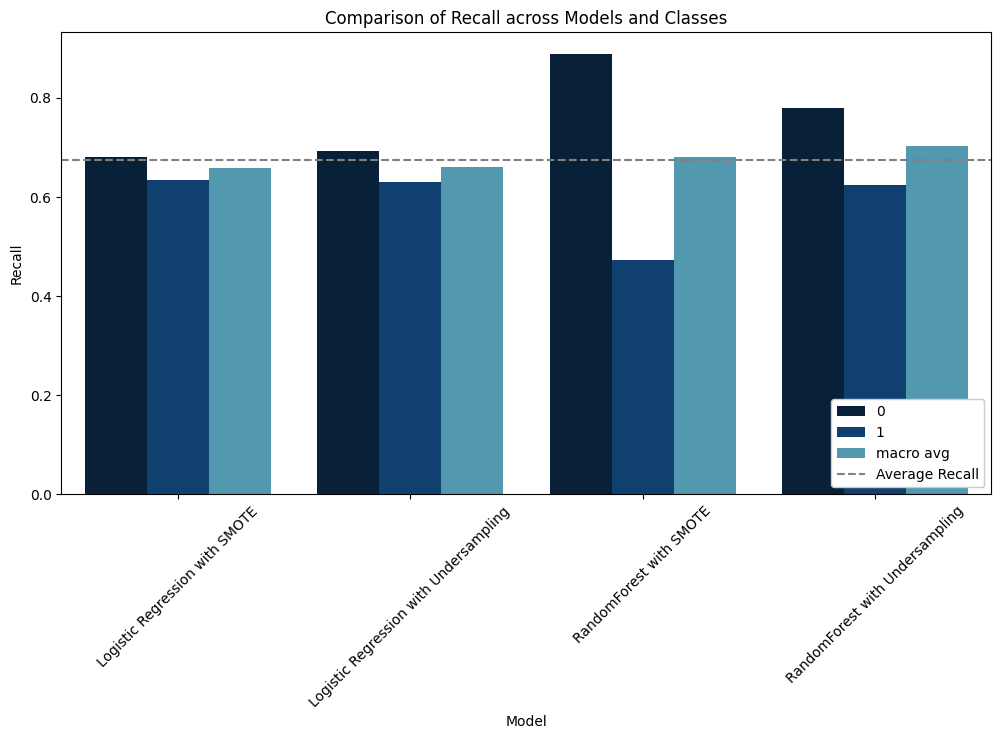

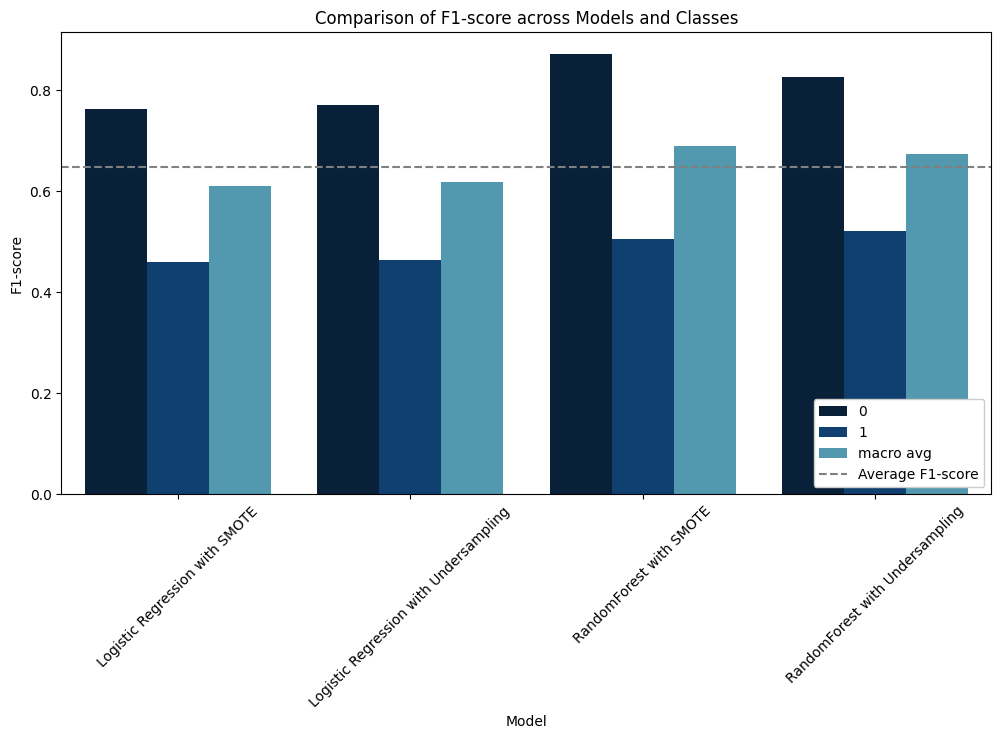

In [6]:
# Assuming `key_metrics_df` is the DataFrame with the extracted key metrics
plot_key_metrics(key_metrics_df, desired_metrics, desired_classes)

#### Analyze Results

#### Key Metrics:
1. **Recall for Class 1**: This is our primary priority.
2. **Macro Average F1-Score**: We also aim to keep this high.

1. **Best Recall for Class 1**: Logistic Regression with SMOTE (0.634514) narrowly outperforms Logistic Regression with Undersampling (0.629239). However, both logistic regression models perform significantly better than the RandomForest models in terms of recall for class 1.
   
2. **Best Macro Average F1-Score**: RandomForest with SMOTE (0.688916) has the highest macro average F1-score, followed by RandomForest with Undersampling (0.673372). However, both RandomForest models perform worse in recall for class 1 compared to Logistic Regression models.

### Recommendations:

1. **Priority on Recall for Class 1**: If recall for class 1 is the absolute priority, Logistic Regression with SMOTE is the best option, closely followed by Logistic Regression with Undersampling.
   
2. **Balancing Recall and Macro Average F1-Score**: If balancing recall for class 1 and maintaining a higher macro average F1-score is important, Logistic Regression with Undersampling might be a better choice due to its slightly better macro average metrics compared to Logistic Regression with SMOTE, while still maintaining a competitive recall for class 1.

3. **RandomForest Models**: While RandomForest models have higher macro average scores, their performance in recall for class 1 is significantly lower, making them less suitable if recall for class 1 is the top priority.

### Final Recommendation:

Given the priority on recall for class 1 and the need to maintain a high F1 macro score, **Logistic Regression with SMOTE** is the recommended model, as it provides the best recall for class 1 while still maintaining a reasonable macro average F1-score.

### Description of Class Weights

**Class weights** are a technique used in machine learning to handle imbalanced datasets. Imbalanced datasets occur when the number of instances in different classes is significantly different, which can lead to models that are biased towards the majority class. Class weights assign different weights to different classes to balance their impact on the model during training.

### What Class Weights Do

1. **Adjust the Importance**:
   - Class weights increase the importance of the minority class in the loss function used to train the model. By giving higher weights to the minority class, the model is penalized more for misclassifying minority class instances.

2. **Modify the Loss Function**:
   - The loss function is adjusted so that errors in the minority class are given more weight. This means that the model will focus more on correctly classifying the minority class, which helps to improve recall and precision for that class.

### Why Class Weights Matter

1. **Improving Model Performance on Minority Class**:
   - In imbalanced datasets, the model might perform well overall but poorly on the minority class. Class weights help ensure that the model pays more attention to the minority class, improving metrics such as recall and precision for that class.

2. **Reducing Bias**:
   - Without class weights, models can become biased towards the majority class, leading to poor generalization and unfair predictions. Class weights help mitigate this bias, leading to fairer and more balanced models.

3. **Enhancing Recall for Critical Applications**:
   - In many real-world applications, recall for the minority class is crucial. For example, in medical diagnostics, fraud detection, and loan default prediction, missing instances of the minority class (false negatives) can have serious consequences. Class weights help to enhance recall, reducing the risk of missing critical instances.

### When to Use Class Weights

1. **Imbalanced Datasets**:
   - Class weights are particularly useful when dealing with imbalanced datasets where the number of instances in one class is much higher than the other(s).

2. **Critical Minority Class**:
   - When the minority class represents critical cases that should not be overlooked, such as detecting diseases, identifying fraud, or predicting rare events.

3. **During Initial Model Training**:
   - Class weights can be used during the initial stages of model training to quickly address class imbalance without the need for complex resampling techniques.

### How to Use Class Weights

In scikit-learn, class weights can be easily implemented by setting the `class_weight` parameter in various classifiers. Here are examples for Logistic Regression and Random Forest:

#### Logistic Regression

```python
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)
```

#### Random Forest

```python
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight='balanced', random_state=42)
```

Setting `class_weight='balanced'` automatically adjusts the weights inversely proportional to class frequencies in the input data.

### Conclusion

Class weights are a powerful tool for handling imbalanced datasets by adjusting the importance of different classes during model training. They help improve the performance on the minority class, reduce bias, and enhance recall for critical applications. By incorporating class weights, you can create more balanced and fair models that perform well across all classes.

### Evaluate Models with Class Weights

Preprocessing pipeline created successfully.


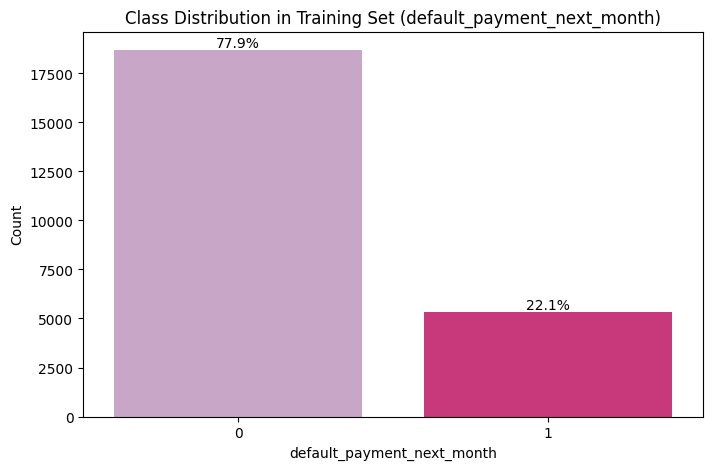

Classification Report for Logistic Regression with Class Weights:
               precision    recall  f1-score   support

           0       0.87      0.69      0.77      4673
           1       0.37      0.63      0.47      1327

    accuracy                           0.68      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.76      0.68      0.70      6000

Classification Report for RandomForest with Class Weights:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.65      0.35      0.45      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.65      0.67      6000
weighted avg       0.80      0.81      0.79      6000

Classification Report for Logistic Regression with SMOTE:
               precision    recall  f1-score   support

           0       0.87      0.68      0.76      4673
           1       0.36      0.63      0.46      13

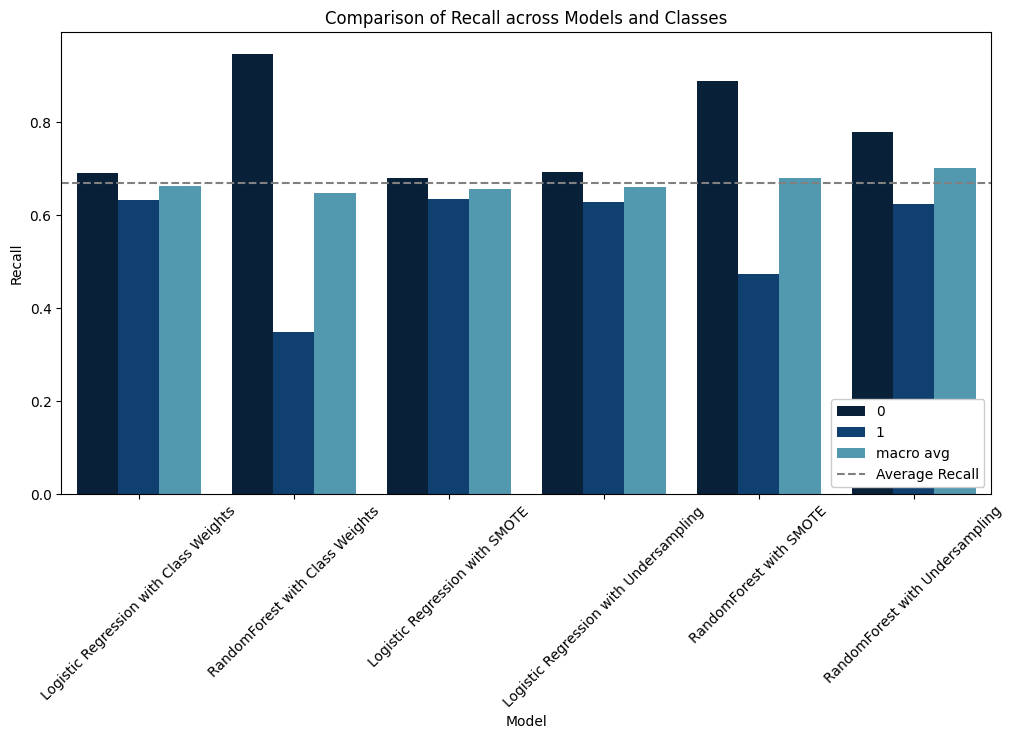

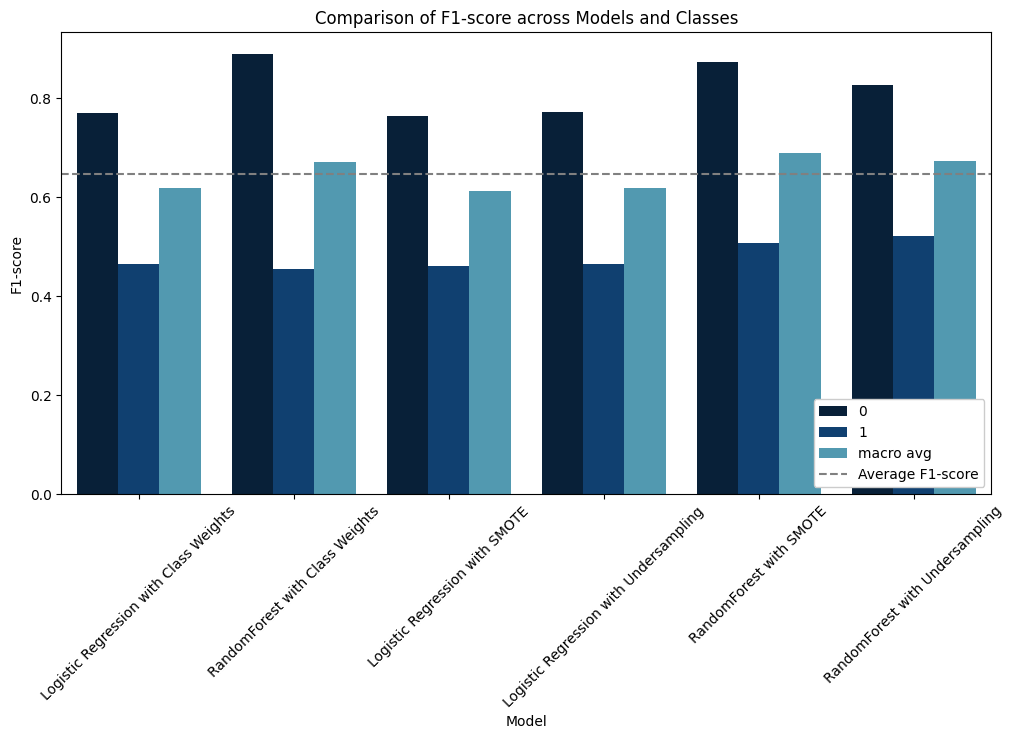

In [7]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from resampling_utils import aggregate_reports, extract_key_metrics, plot_key_metrics
from data_utils import preprocess_data, split_data, create_preprocessing_pipeline, plot_class_distribution, create_weighted_model, evaluate_model

# Define your parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and Preprocess Data
data = preprocess_data(url, categorical_columns)
if data is not None:
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()
    pipeline = create_preprocessing_pipeline(numeric_features, categorical_features)
    plot_class_distribution(y_train, target)
else:
    print("Data preprocessing failed. Please check the URL and preprocessing steps.")

# Initialize an empty list to store all reports
all_reports = []

# Logistic Regression with Class Weights
log_reg_model_weighted = create_weighted_model('logistic_regression')
pipeline_with_log_reg_weighted = add_model_to_pipeline(pipeline, log_reg_model_weighted)
pipeline_with_log_reg_weighted.fit(X_train, y_train)
y_pred_log_reg_weighted = pipeline_with_log_reg_weighted.predict(X_test)
report_log_reg_weighted = evaluate_model(pipeline_with_log_reg_weighted, X_test, y_test, "Logistic Regression with Class Weights")
all_reports.append(report_log_reg_weighted)

# RandomForest with Class Weights
rf_model_weighted = create_weighted_model('random_forest')
pipeline_with_rf_weighted = add_model_to_pipeline(pipeline, rf_model_weighted)
pipeline_with_rf_weighted.fit(X_train, y_train)
y_pred_rf_weighted = pipeline_with_rf_weighted.predict(X_test)
report_rf_weighted = evaluate_model(pipeline_with_rf_weighted, X_test, y_test, "RandomForest with Class Weights")
all_reports.append(report_rf_weighted)

# Define the key metrics and classes you want to focus on
desired_metrics = ['recall', 'f1-score']
desired_classes = ['0', '1', 'macro avg']

# Logistic Regression with SMOTE
model = LogisticRegression(max_iter=500, random_state=42)
smote = SMOTE(random_state=42)
pipeline_with_smote = ImbPipeline(steps=[
    ('preprocessor', pipeline.named_steps['preprocessor']),
    ('smote', smote),
    ('model', model)
])
pipeline_with_smote.fit(X_train, y_train)
y_pred_smote = pipeline_with_smote.predict(X_test)
report_smote = evaluate_model(pipeline_with_smote, X_test, y_test, "Logistic Regression with SMOTE")
all_reports = aggregate_reports(all_reports, report_smote)

# Logistic Regression with Undersampling
undersample = RandomUnderSampler(random_state=42)
pipeline_with_undersample = ImbPipeline(steps=[
    ('preprocessor', pipeline.named_steps['preprocessor']),
    ('undersample', undersample),
    ('model', model)
])
pipeline_with_undersample.fit(X_train, y_train)
y_pred_undersample = pipeline_with_undersample.predict(X_test)
report_undersample = evaluate_model(pipeline_with_undersample, X_test, y_test, "Logistic Regression with Undersampling")
all_reports = aggregate_reports(all_reports, report_undersample)

# RandomForest with SMOTE
rf_model = RandomForestClassifier(random_state=42)
pipeline_with_rf_smote = ImbPipeline(steps=[
    ('preprocessor', pipeline.named_steps['preprocessor']),
    ('smote', smote),
    ('model', rf_model)
])
pipeline_with_rf_smote.fit(X_train, y_train)
y_pred_rf_smote = pipeline_with_rf_smote.predict(X_test)
report_rf_smote = evaluate_model(pipeline_with_rf_smote, X_test, y_test, "RandomForest with SMOTE")
all_reports = aggregate_reports(all_reports, report_rf_smote)

# RandomForest with Undersampling
pipeline_with_rf_undersample = ImbPipeline(steps=[
    ('preprocessor', pipeline.named_steps['preprocessor']),
    ('undersample', undersample),
    ('model', rf_model)
])
pipeline_with_rf_undersample.fit(X_train, y_train)
y_pred_rf_undersample = pipeline_with_rf_undersample.predict(X_test)
report_rf_undersample = evaluate_model(pipeline_with_rf_undersample, X_test, y_test, "RandomForest with Undersampling")
all_reports = aggregate_reports(all_reports, report_rf_undersample)

# Extract and display the key metrics
key_metrics_df = extract_key_metrics(all_reports, desired_metrics, desired_classes)

# Plot key metrics
plot_key_metrics(key_metrics_df, desired_metrics, desired_classes)


#### Result Table

In [8]:
key_metrics_df

,model,class,metric,value
0,Logistic Regression with Class Weights,0,recall,0.691419
1,Logistic Regression with Class Weights,0,f1-score,0.770019
2,Logistic Regression with Class Weights,1,recall,0.632253
3,Logistic Regression with Class Weights,1,f1-score,0.465078
4,Logistic Regression with Class Weights,macro avg,recall,0.661836
5,Logistic Regression with Class Weights,macro avg,f1-score,0.617548
6,RandomForest with Class Weights,0,recall,0.946501
7,RandomForest with Class Weights,0,f1-score,0.888153
8,RandomForest with Class Weights,1,recall,0.348907
9,RandomForest with Class Weights,1,f1-score,0.453922


#### Analysis of Results

Our primary priority is recall for class 1, and we also want to maintain a high F1 macro score. Below is a detailed analysis of the results, focusing on these priorities:

#### Summary of Key Metrics:

1. **Recall for Class 1 (Priority)**
2. **F1-Score for Class 1**
3. **Macro Average Recall**
4. **Macro Average F1-Score**


### Recommendations:

1. **Priority on Recall for Class 1**:
   - **Best Options**:
     - **Logistic Regression with SMOTE**: 0.634514
     - **Logistic Regression with Class Weights**: 0.632253
     - **Logistic Regression with Undersampling**: 0.629239
   - These models have the highest recall for class 1, which is our primary priority.

2. **Balancing Recall and Macro Average F1-Score**:
   - **RandomForest with Undersampling**: Offers a good balance with a decent recall for class 1 (0.624717) and a high macro average F1-score (0.673372).
   - **RandomForest with SMOTE**: Provides a moderate balance with a recall for class 1 (0.472494) and the highest macro average F1-score (0.688916).

### Final Recommendation:

Given the priority on recall for class 1 and the need to maintain a high F1 macro score, **Logistic Regression with SMOTE** and **Logistic Regression with Class Weights** are the recommended models for their high recall for class 1. If a balance between recall and F1 macro is preferred, **RandomForest with Undersampling** is a viable option.

### Threshold

### Predict Probabilities

In [14]:
# Predict probabilities for the test set
y_pred_prob_log_reg_weighted = pipeline_with_log_reg_weighted.predict_proba(X_test)[:, 1]
y_pred_prob_rf_weighted = pipeline_with_rf_weighted.predict_proba(X_test)[:, 1]

### Evaluate Different Thresholds

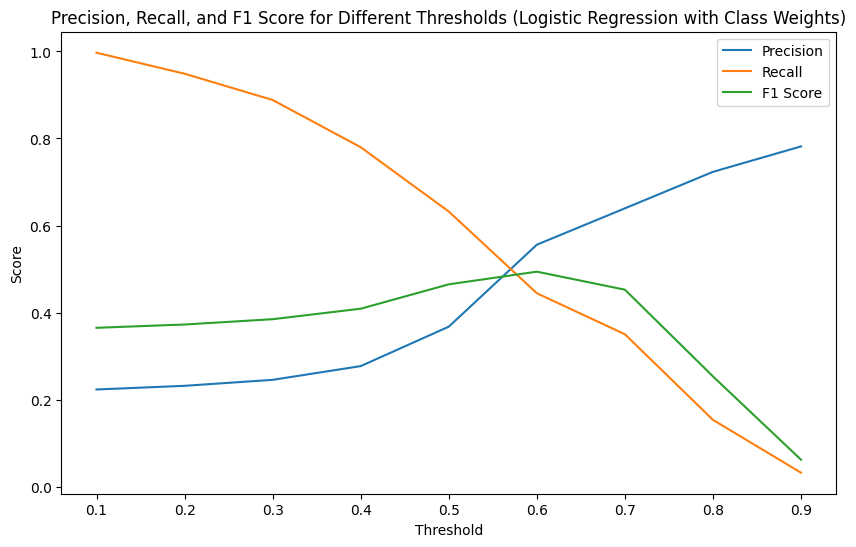

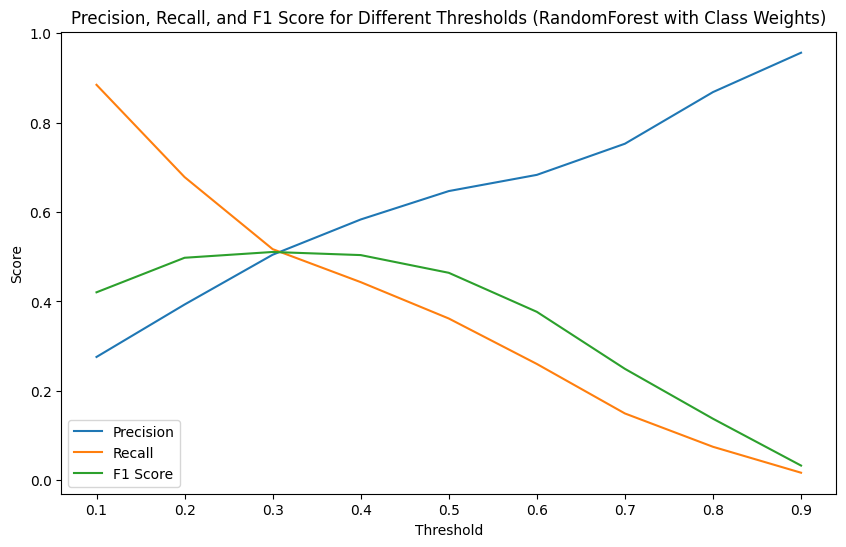

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_thresholds(y_true, y_pred_prob, thresholds, model_name):
    results = []
    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        results.append({'threshold': threshold, 'precision': precision, 'recall': recall, 'f1': f1})

    results_df = pd.DataFrame(results)

    plt.figure(figsize=(10, 6))
    plt.plot(results_df['threshold'], results_df['precision'], label='Precision')
    plt.plot(results_df['threshold'], results_df['recall'], label='Recall')
    plt.plot(results_df['threshold'], results_df['f1'], label='F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'Precision, Recall, and F1 Score for Different Thresholds ({model_name})')
    plt.legend()
    plt.show()

    return results_df

# Define thresholds to evaluate
thresholds = np.arange(0.1, 1.0, 0.1)

# Predict probabilities for the test set
y_pred_prob_log_reg_weighted = pipeline_with_log_reg_weighted.predict_proba(X_test)[:, 1]
y_pred_prob_rf_weighted = pipeline_with_rf_weighted.predict_proba(X_test)[:, 1]

# Evaluate thresholds for Logistic Regression with Class Weights
results_log_reg_weighted = evaluate_thresholds(y_test, y_pred_prob_log_reg_weighted, thresholds, "Logistic Regression with Class Weights")

# Evaluate thresholds for RandomForest with Class Weights
results_rf_weighted = evaluate_thresholds(y_test, y_pred_prob_rf_weighted, thresholds, "RandomForest with Class Weights")


In [23]:
results_log_reg_weighted['model'] = 'Logistic Regression with Class Weights'
results_log_reg_weighted

,threshold,precision,recall,f1,model
0,0.1,0.223555,0.996986,0.365217,Logistic Regression with Class Weights
1,0.2,0.231988,0.948757,0.372816,Logistic Regression with Class Weights
2,0.3,0.245727,0.888470,0.384980,Logistic Regression with Class Weights
3,0.4,0.277257,0.779955,0.409091,Logistic Regression with Class Weights
4,0.5,0.367821,0.632253,0.465078,Logistic Regression with Class Weights
5,0.6,0.556079,0.444612,0.494137,Logistic Regression with Class Weights
6,0.7,0.639615,0.350414,0.452775,Logistic Regression with Class Weights
7,0.8,0.723404,0.153730,0.253574,Logistic Regression with Class Weights
8,0.9,0.781818,0.032404,0.062229,Logistic Regression with Class Weights


In [21]:
results_rf_weighted['model'] = 'RandomForest with Class Weights'
results_rf_weighted

,threshold,precision,recall,f1,model
0,0.1,0.275652,0.884702,0.420337,RandomForest with Class Weights
1,0.2,0.393013,0.678222,0.497650,RandomForest with Class Weights
2,0.3,0.504412,0.516956,0.510607,RandomForest with Class Weights
3,0.4,0.583333,0.443105,0.503640,RandomForest with Class Weights
4,0.5,0.646900,0.361718,0.463992,RandomForest with Class Weights
5,0.6,0.683168,0.259985,0.376638,RandomForest with Class Weights
6,0.7,0.752852,0.149209,0.249057,RandomForest with Class Weights
7,0.8,0.868421,0.074604,0.137405,RandomForest with Class Weights
8,0.9,0.956522,0.016579,0.032593,RandomForest with Class Weights


#### Understanding the Results

The results for Logistic Regression with Class Weights and RandomForest with Class Weights at different thresholds show varying performance in terms of precision, recall, and F1-score. The optimal threshold and model choice depend on the specific trade-offs you are willing to make between precision and recall.

### Key Observations

1. **Logistic Regression with Class Weights**:
   - High recall at lower thresholds (e.g., 0.1) but very low precision.
   - Precision improves as the threshold increases, but recall drops significantly.
   - The F1-score is balanced at around a threshold of 0.4-0.6.

2. **RandomForest with Class Weights**:
   - Similar pattern with high recall and low precision at lower thresholds.
   - The F1-score is relatively balanced around a threshold of 0.2-0.4.
   - Higher thresholds result in very low recall but high precision.

### Choosing the Path Forward

1. **Select the Best Performing Models**:
   - Based on your priorities (high recall for class 1, balanced F1 macro), choose two models that show the most promise. In this case, you might choose:
     - Logistic Regression with Class Weights: Threshold around 0.4-0.5
     - RandomForest with Class Weights: Threshold around 0.2-0.4

2. **Optimize Hyperparameters**:
   - Optimize the hyperparameters for each selected model separately, as optimal parameters for one model will not be optimal for the other.
   - Use GridSearchCV or RandomizedSearchCV to find the best hyperparameters for each model.

3. **Evaluate and Compare**:
   - Evaluate the optimized models using cross-validation to ensure robustness.
   - Compare their performance using your key metrics (recall for class 1, F1-score, and F1 macro).

4. **Consider Ensemble Methods**:
   - If both models have complementary strengths, consider combining them using ensemble methods like stacking, voting, or bagging to leverage their individual strengths.

### Steps to Implement

#### Step 1: Hyperparameter Optimization

Use GridSearchCV or RandomizedSearchCV to find the optimal hyperparameters for both models.

```python
from sklearn.model_selection import GridSearchCV

# Define parameter grids for each model
param_grid_log_reg = {
    'model__C': [0.1, 1, 10],
    'model__solver': ['liblinear', 'lbfgs']
}

param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

# Optimize Logistic Regression
grid_search_log_reg = GridSearchCV(pipeline_with_log_reg_weighted, param_grid_log_reg, cv=5, scoring='f1', n_jobs=-1)
grid_search_log_reg.fit(X_train, y_train)
best_log_reg = grid_search_log_reg.best_estimator_

# Optimize Random Forest
grid_search_rf = GridSearchCV(pipeline_with_rf_weighted, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
```

#### Step 2: Evaluate Optimized Models

Evaluate the optimized models at various thresholds to find the best threshold for each.

```python
# Predict probabilities for the optimized models
y_pred_prob_best_log_reg = best_log_reg.predict_proba(X_test)[:, 1]
y_pred_prob_best_rf = best_rf.predict_proba(X_test)[:, 1]

# Evaluate thresholds for optimized Logistic Regression
results_best_log_reg = evaluate_thresholds(y_test, y_pred_prob_best_log_reg, thresholds, "Optimized Logistic Regression with Class Weights")

# Evaluate thresholds for optimized Random Forest
results_best_rf = evaluate_thresholds(y_test, y_pred_prob_best_rf, thresholds, "Optimized Random Forest with Class Weights")
```

#### Step 3: Ensemble Methods (Optional)

Consider combining the strengths of both models using ensemble methods.

```python
from sklearn.ensemble import VotingClassifier

# Combine models using voting
ensemble = VotingClassifier(estimators=[
    ('log_reg', best_log_reg.named_steps['model']),
    ('rf', best_rf.named_steps['model'])
], voting='soft')

ensemble.fit(X_train, y_train)

# Evaluate the ensemble model
y_pred_prob_ensemble = ensemble.predict_proba(X_test)[:, 1]
results_ensemble = evaluate_thresholds(y_test, y_pred_prob_ensemble, thresholds, "Ensemble of Optimized Models")
```

### Summary

1. **Optimize Hyperparameters**: Use GridSearchCV to find the best hyperparameters for each model.
2. **Evaluate Thresholds**: Determine the optimal thresholds for each model based on your key metrics.
3. **Ensemble Methods**: Consider combining the models using ensemble methods to leverage their strengths.
4. **Compare and Select**: Choose the model or ensemble that best meets your performance criteria.

By following these steps, you can ensure that you are getting the best performance from your models and making the most informed decisions based on your specific priorities and constraints.

#### Order of Operations for Model Optimization

To achieve the best model performance, it's crucial to follow a systematic order of operations. Here’s a recommended sequence:

1. **Data Preprocessing**: Clean, transform, and prepare the data.
2. **Initial Model Training**: Train baseline models with default settings to understand the data and initial performance.
3. **Resampling Techniques**: Apply resampling methods (oversampling, undersampling, SMOTE, etc.) to handle class imbalance and train models.
4. **Threshold Adjustment**: Adjust the decision threshold to optimize for key metrics such as recall, precision, and F1-score.
5. **Hyperparameter Tuning**: Optimize the model’s hyperparameters using techniques like GridSearchCV or RandomizedSearchCV.
6. **Model Evaluation and Comparison**: Evaluate the models on the test set, compare their performance using the key metrics, and choose the best model.
7. **Ensemble Methods (Optional)**: Combine multiple models to leverage their strengths.
8. **Final Model Training**: Train the final model(s) with the optimal settings (resampling method, hyperparameters, threshold).
9. **Deployment and Monitoring**: Deploy the model and continuously monitor its performance.

### Next Steps

Based on the steps outlined above, here's how you should proceed:

1. **Final Resampling Experiment**:
   - Now that you have identified the optimal threshold for each model, re-run the resampling experiment with this threshold to ensure that the resampling method is optimized for the adjusted threshold.

2. **Hyperparameter Tuning with Optimal Resampling and Threshold**:
   - Once you’ve identified the best resampling method for the optimal threshold, proceed with hyperparameter tuning for the models using this resampling method.

3. **Evaluate and Compare Models**:
   - Evaluate the models using the test set and compare their performance using the key metrics.

### Implementation Steps

#### Step 1: Re-run Resampling Experiments

Re-run the resampling experiments using the identified optimal thresholds.

```python
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model_with_threshold(model, X_test, y_test, threshold, model_name):
    """
    Evaluate the model using a specific threshold and return the classification report as a dictionary.

    Parameters:
    - model: trained model
    - X_test: test features
    - y_test: true labels
    - threshold: decision threshold
    - model_name: name of the model

    Returns:
    - dict: classification report dictionary with model name included
    """
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_prob >= threshold).astype(int)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    report_dict = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'model': model_name,
        'threshold': threshold
    }
    
    print(f"Evaluation for {model_name} at threshold {threshold}:\n Precision: {precision}, Recall: {recall}, F1: {f1}")
    return report_dict

# Example: Logistic Regression with SMOTE at optimal threshold
optimal_threshold_log_reg_smote = 0.4  # replace with your identified threshold
optimal_threshold_rf_smote = 0.3  # replace with your identified threshold

# Re-run resampling experiments with optimal threshold
y_pred_prob_log_reg_smote = pipeline_with_smote.predict_proba(X_test)[:, 1]
report_log_reg_smote = evaluate_model_with_threshold(pipeline_with_smote, X_test, y_test, optimal_threshold_log_reg_smote, "Logistic Regression with SMOTE")

y_pred_prob_rf_smote = pipeline_with_rf_smote.predict_proba(X_test)[:, 1]
report_rf_smote = evaluate_model_with_threshold(pipeline_with_rf_smote, X_test, y_test, optimal_threshold_rf_smote, "RandomForest with SMOTE")
```

#### Step 2: Hyperparameter Tuning with Optimal Resampling and Threshold

Proceed with hyperparameter tuning using GridSearchCV or RandomizedSearchCV, incorporating the optimal resampling method and threshold.

```python
from sklearn.model_selection import GridSearchCV

# Define parameter grids for each model
param_grid_log_reg = {
    'model__C': [0.1, 1, 10],
    'model__solver': ['liblinear', 'lbfgs']
}

param_grid_rf = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

# Logistic Regression with SMOTE
grid_search_log_reg_smote = GridSearchCV(pipeline_with_smote, param_grid_log_reg, cv=5, scoring='f1', n_jobs=-1)
grid_search_log_reg_smote.fit(X_train, y_train)
best_log_reg_smote = grid_search_log_reg_smote.best_estimator_

# RandomForest with SMOTE
grid_search_rf_smote = GridSearchCV(pipeline_with_rf_smote, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_search_rf_smote.fit(X_train, y_train)
best_rf_smote = grid_search_rf_smote.best_estimator_
```

#### Step 3: Evaluate Optimized Models with Optimal Threshold

```python
# Evaluate optimized Logistic Regression with SMOTE
report_best_log_reg_smote = evaluate_model_with_threshold(best_log_reg_smote, X_test, y_test, optimal_threshold_log_reg_smote, "Optimized Logistic Regression with SMOTE")

# Evaluate optimized RandomForest with SMOTE
report_best_rf_smote = evaluate_model_with_threshold(best_rf_smote, X_test, y_test, optimal_threshold_rf_smote, "Optimized RandomForest with SMOTE")
```

### Conclusion

1. **Re-run Resampling with Optimal Threshold**: Ensure that the resampling method is optimal for the adjusted threshold.
2. **Hyperparameter Tuning**: Optimize the model’s hyperparameters using the optimal resampling method and threshold.
3. **Final Evaluation**: Evaluate the optimized models on the test set and compare their performance using key metrics.
4. **Select the Best Model**: Choose the model that best meets your performance criteria for deployment.

By following these steps, you can ensure that you are getting the best performance from your models, considering both resampling methods and threshold adjustments.

#### Write Data Utils Script

In [9]:
script_content = r'''
# data_utils.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Load the dataset from a URL
def load_data_from_url(url):
    """
    Load the dataset from a specified URL.

    Parameters:
    - url: str, URL of the dataset

    Returns:
    - pd.DataFrame, loaded dataset
    """
    try:
        df = pd.read_excel(url, header=1)
    except Exception as e:
        print(f"Error loading data from URL: {e}")
        return None
    return df

# Clean column names
def clean_column_names(df):
    """
    Clean the column names by converting to lowercase and replacing spaces with underscores.

    Parameters:
    - df: pd.DataFrame, input dataframe

    Returns:
    - pd.DataFrame, dataframe with cleaned column names
    """
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

# Remove the 'id' column
def remove_id_column(df):
    """
    Remove the 'id' column if it exists.

    Parameters:
    - df: pd.DataFrame, input dataframe

    Returns:
    - pd.DataFrame, dataframe without 'id' column
    """
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

# Rename columns (pay_0 not in dataset)
def rename_columns(df):
    """
    Rename specific columns based on a predefined dictionary.

    Parameters:
    - df: pd.DataFrame, input dataframe

    Returns:
    - pd.DataFrame, dataframe with renamed columns
    """
    rename_dict = {
        'pay_0': 'pay_1'
    }
    df = df.rename(columns=rename_dict)
    return df

# Convert specified columns to categorical type
def convert_categorical(df, categorical_columns):
    """
    Convert specified columns to categorical type.

    Parameters:
    - df: pd.DataFrame, input dataframe
    - categorical_columns: list of str, columns to convert to categorical type

    Returns:
    - pd.DataFrame, dataframe with converted columns
    """
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

# Split the data into training and testing sets
def split_data(df, target):
    """
    Split the data into training and testing sets.

    Parameters:
    - df: pd.DataFrame, input dataframe
    - target: str, name of the target column

    Returns:
    - tuple, (X_train, X_test, y_train, y_test)
    """
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

def preprocess_data(url, categorical_columns):
    """
    Load and preprocess the data.

    Parameters:
    - url: str, URL of the dataset
    - categorical_columns: list of str, columns to convert to categorical type

    Returns:
    - pd.DataFrame, preprocessed data
    """
    # Load the dataset
    data = load_data_from_url(url)

    if data is None:
        return None

    # Clean column names
    data = clean_column_names(data)

    # Remove the 'id' column
    data = remove_id_column(data)

    # Rename columns
    data = rename_columns(data)

    # Convert specified columns to categorical type
    data = convert_categorical(data, categorical_columns)

    return data

# Plot class balance in the training set with ratio annotations
def plot_class_distribution(y_train, target):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='PuRd')
    plt.title(f'Class Distribution in Training Set ({target})')
    plt.xlabel(target)
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)  # Turn off the legend

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

def create_preprocessing_pipeline(numeric_features, categorical_features):
    """
    Create a preprocessing pipeline for numeric and categorical features.

    Parameters:
    - numeric_features: list of str, names of numeric features
    - categorical_features: list of str, names of categorical features

    Returns:
    - sklearn.pipeline.Pipeline, the complete preprocessing pipeline
    """
    # Define the transformers for numerical and categorical data
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine the transformers using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    # Create the full pipeline with preprocessing and a placeholder for the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
        # You can add your model here, e.g., ('model', RandomForestClassifier())
    ])

    print("Preprocessing pipeline created successfully.")
    return pipeline

def add_model_to_pipeline(pipeline, model):
    """
    Add a model to the preprocessing pipeline.

    Parameters:
    - pipeline: sklearn.pipeline.Pipeline, the preprocessing pipeline
    - model: sklearn estimator, the model to add to the pipeline

    Returns:
    - sklearn.pipeline.Pipeline, the complete pipeline with the model added
    """
    return Pipeline(steps=pipeline.steps + [('model', model)])

def evaluate_model(pipeline, X_test, y_test, model_name):
    """
    Evaluate the model using the test data.

    Parameters:
    - pipeline: sklearn.pipeline.Pipeline, the complete pipeline with preprocessing and model
    - X_test: pd.DataFrame or np.ndarray, the test features
    - y_test: pd.Series or np.ndarray, the test labels
    - model_name: str, name of the model

    Returns:
    - dict, the classification report with the model name included
    """
    y_pred = pipeline.predict(X_test)
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report_dict['model'] = model_name
    print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred))
    return report_dict

def hyperparameter_tuning(pipeline, param_grid, X_train, y_train):
    """
    Perform hyperparameter tuning using GridSearchCV.

    Parameters:
    - pipeline: sklearn.pipeline.Pipeline, the complete pipeline with preprocessing and model
    - param_grid: dict, the parameter grid for GridSearchCV
    - X_train: pd.DataFrame or np.ndarray, the training features
    - y_train: pd.Series or np.ndarray, the training labels

    Returns:
    - sklearn estimator, the best estimator found by GridSearchCV
    """
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best Parameters:\n", grid_search.best_params_)
    return grid_search.best_estimator_

def create_weighted_model(model_type, class_weight='balanced', random_state=42):
    """
    Create a model with class weights.

    Parameters:
    - model_type: str, type of the model ('logistic_regression' or 'random_forest')
    - class_weight: dict or 'balanced', class weights
    - random_state: int, random state for reproducibility

    Returns:
    - sklearn estimator, the model with class weights
    """
    if model_type == 'logistic_regression':
        model = LogisticRegression(class_weight=class_weight, max_iter=500, random_state=random_state)
    elif model_type == 'random_forest':
        model = RandomForestClassifier(class_weight=class_weight, random_state=random_state)
    else:
        raise ValueError("Unsupported model type. Use 'logistic_regression' or 'random_forest'.")

    return model

'''

# Write the script to a file
with open("data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to data_utils.py")

# Reload script to make functions available for use
import importlib
import data_utils
importlib.reload(data_utils)

from data_utils import (load_data_from_url, clean_column_names, remove_id_column,
                        rename_columns, convert_categorical, preprocess_data, split_data, plot_class_distribution,
                        create_preprocessing_pipeline, add_model_to_pipeline, evaluate_model,
                        hyperparameter_tuning, create_weighted_model)


Script successfully written to data_utils.py


#### Write Resampling Utils Script

In [17]:
script_content = r'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluate the model and return the classification report as a dictionary.

    Parameters:
    - y_true: array-like, true labels
    - y_pred: array-like, predicted labels
    - model_name: str, name of the model

    Returns:
    - dict, classification report dictionary
    """
    report_dict = classification_report(y_true, y_pred, output_dict=True)

    # Print the classification report
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred))

    # Add model name to the dictionary
    report_dict['model'] = model_name

    return report_dict

def aggregate_reports(reports_list, new_report):
    """
    Aggregate classification reports into a list.

    Parameters:
    - reports_list: list, list of classification reports
    - new_report: dict, new classification report to add

    Returns:
    - list, updated list of classification reports
    """
    reports_list.append(new_report)
    return reports_list

def extract_key_metrics(reports_list, metrics, classes):
    """
    Extract key metrics from the aggregated classification reports.

    Parameters:
    - reports_list: list, list of classification reports
    - metrics: list of str, metrics to extract
    - classes: list of str, classes to include in the comparison

    Returns:
    - pd.DataFrame, DataFrame with the selected metrics
    """
    extracted_metrics = []

    for report in reports_list:
        model_name = report['model']
        for cls in classes:
            for metric in metrics:
                metric_value = report[cls][metric]
                extracted_metrics.append({
                    'model': model_name,
                    'class': cls,
                    'metric': metric,
                    'value': metric_value
                })

    return pd.DataFrame(extracted_metrics)

def plot_key_metrics(metrics_df, metrics, classes):
    """
    Plot key metrics from the aggregated classification reports.

    Parameters:
    - metrics_df: pd.DataFrame, DataFrame containing the extracted metrics
    - metrics: list of str, metrics to plot (e.g., ['recall', 'f1-score'])
    - classes: list of str, classes to include in the plot

    Returns:
    - None
    """
    primary_metric = metrics[0]
    secondary_metric = metrics[1] if len(metrics) > 1 else None

    for metric in metrics:
        plt.figure(figsize=(12, 6))

        # Filter the DataFrame for the current metric
        metric_df = metrics_df[metrics_df['metric'] == metric]

        # Plot the bar plot
        sns.barplot(data=metric_df, x='model', y='value', hue='class', palette='ocean')
        plt.title(f'Comparison of {metric.capitalize()} across Models and Classes')
        plt.xlabel('Model')
        plt.ylabel(metric.capitalize())
        plt.legend(title='Class', loc='lower right', framealpha=1.0)
        plt.xticks(rotation=45)

        # Calculate and plot the average line for the primary and secondary metrics
        if metric == primary_metric or metric == secondary_metric:
            avg_metric_value = metric_df['value'].mean()
            plt.axhline(avg_metric_value, color='0.5', linestyle='--', label=f'Average {metric.capitalize()}')
            plt.legend(loc='lower right', framealpha=1.0)

        plt.show()

def evaluate_thresholds(y_true, y_pred_prob, thresholds, model_name):
    results = []
    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        results.append({'threshold': threshold, 'precision': precision, 'recall': recall, 'f1': f1})

    results_df = pd.DataFrame(results)

    plt.figure(figsize=(10, 6))
    plt.plot(results_df['threshold'], results_df['precision'], label='Precision')
    plt.plot(results_df['threshold'], results_df['recall'], label='Recall')
    plt.plot(results_df['threshold'], results_df['f1'], label='F1 Score')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'Precision, Recall, and F1 Score for Different Thresholds ({model_name})')
    plt.legend()
    plt.show()

    return results_df

'''

# Write the script to a file
with open("resampling_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to resampling_utils.py")

# Reload script to make functions available for use
import importlib
import resampling_utils
importlib.reload(resampling_utils)

from resampling_utils import evaluate_model, aggregate_reports, extract_key_metrics, plot_key_metrics, evaluate_thresholds


Script successfully written to resampling_utils.py
